In [1]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Running on CPU.")

2.6.0+cu124
True
Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/archive.zip" -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1649.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1651.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1654.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1656.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1657.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1660.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1661.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-25-Centipede-1662.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1664.jpg  
  inflating: /content/COD10K-v3/Train/Image/COD10K-CAM-2-Terrestrial-26-Chameleon-1665.jpg  
  inflating: 

In [4]:
import os
print(os.listdir('/content/COD10K-v3'))

['Readme.txt', 'Info', 'Train', 'Test']


In [5]:
train_path = '/content/COD10K-v3/Train'
test_path = '/content/COD10K-v3/Test'

def get_subfolders(base_path):
    return {
        'image': f'{base_path}/Image',
        'gt_object': f'{base_path}/GT_Object',
        'gt_edge': f'{base_path}/GT_Edge',
        'gt_instance': f'{base_path}/GT_Instance'
    }

train_folders = get_subfolders(train_path)
test_folders = get_subfolders(test_path)

In [6]:
import os

def count_files(folder_dict):
    for key, folder in folder_dict.items():
        print(f"{key}: {len(os.listdir(folder))} files")

print("Train set:")
count_files(train_folders)
print("\nTest set:")
count_files(test_folders)

Train set:
image: 6000 files
gt_object: 6000 files
gt_edge: 6000 files
gt_instance: 6000 files

Test set:
image: 4000 files
gt_object: 4000 files
gt_edge: 4000 files
gt_instance: 4000 files


In [7]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [16]:
class COD10KDataset(Dataset):
    def __init__(self, folders, transform=None, mask_transform=None):
        self.image_paths = sorted(os.listdir(folders['image']))
        self.image_dir = folders['image']
        self.mask_dir = folders['gt_object']
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.image_paths[idx]
        img_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name.replace('.jpg', '.png'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = COD10KDataset(folders=train_folders, transform=transform, mask_transform=mask_transform)
test_dataset = COD10KDataset(folders=test_folders, transform=transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [10]:
images, masks = next(iter(train_loader))

print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 1, 256, 256])


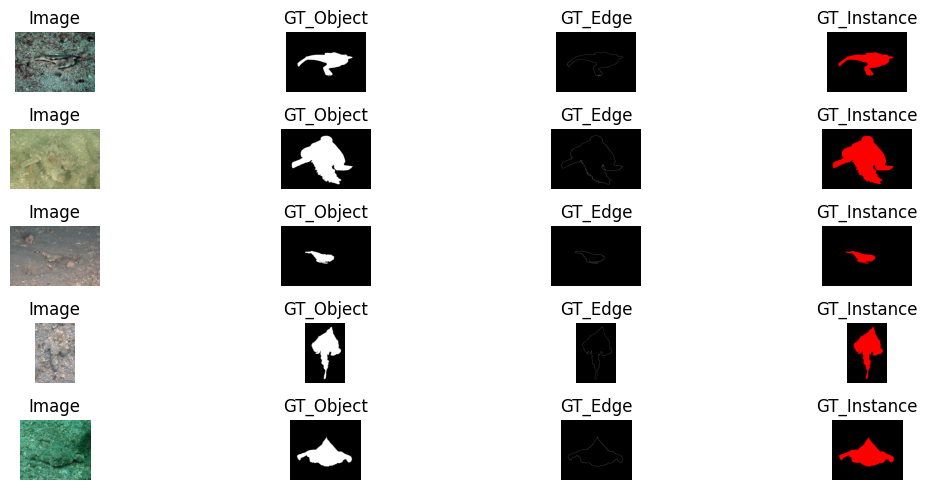

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_all_types(folders, indices):
    n = len(indices)
    fig, axes = plt.subplots(n, 4, figsize=(12, 5))
    type_names = ['Image', 'GT_Object', 'GT_Edge', 'GT_Instance']
    image_files = sorted(os.listdir(folders['image']))
    for row, idx in enumerate(indices):
        img_name = image_files[idx]
        paths = [
            os.path.join(folders['image'], img_name),
            os.path.join(folders['gt_object'], img_name.replace('.jpg', '.png')),
            os.path.join(folders['gt_edge'], img_name.replace('.jpg', '.png')),
            os.path.join(folders['gt_instance'], img_name.replace('.jpg', '.png'))
        ]
        for col, (path, tname) in enumerate(zip(paths, type_names)):
            img = Image.open(path)
            axes[row, col].imshow(img if col == 0 else img, cmap=None if col == 0 else 'gray')
            axes[row, col].set_title(tname)
            axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

show_all_types(train_folders, indices=range(5))


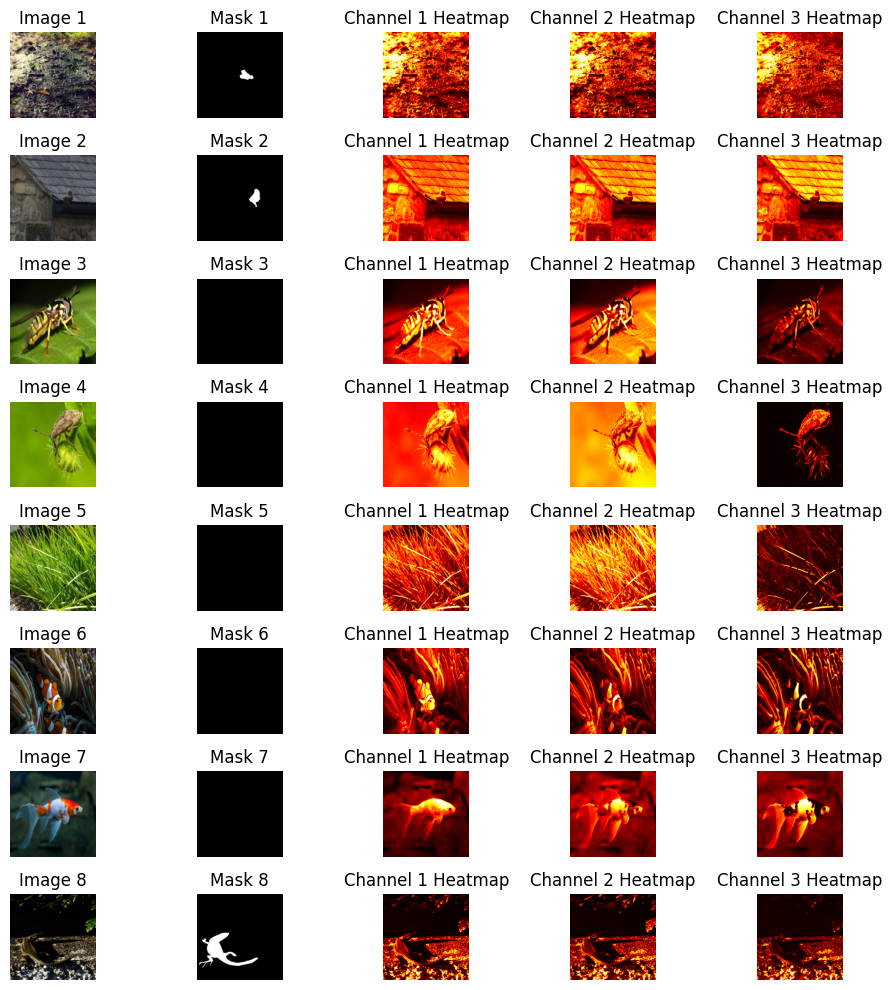

In [14]:
import torch
import matplotlib.pyplot as plt

def show_images_and_heatmaps(images, masks, num_images=8):
    batch_size = images.shape[0]
    num_images = min(num_images, batch_size)
    fig, axes = plt.subplots(num_images, 5, figsize=(10, 10))
    if num_images == 1:
        axes = axes.reshape(1, 5)
    for i in range(num_images):
        axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu())
        axes[i, 0].set_title(f'Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i].squeeze().cpu(), cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

        for c in range(3):
            heatmap = images[i, c].cpu()
            axes[i, c+2].imshow(heatmap, cmap='hot')
            axes[i, c+2].set_title(f'Channel {c+1} Heatmap')
            axes[i, c+2].axis('off')
    plt.tight_layout()
    plt.show()

show_images_and_heatmaps(images, masks, num_images=8)



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ENTO(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU()
        )
        self.enrich = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Upsample(scale_factor=2)
        )
        self.base = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Upsample(scale_factor=2)
        )
        self.retouch = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.enrich(x)
        x = self.base(x)
        x = self.retouch(x)
        return x

In [20]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define mask_transform explicitly
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


train_dataset = COD10KDataset(folders=train_folders, transform=transform, mask_transform=mask_transform)
test_dataset = COD10KDataset(folders=test_folders, transform=transform, mask_transform=mask_transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_ento = ENTO().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ento.parameters(), lr=0.001)

num_epochs = 30
train_losses = []

print("Starting ENTO training on COD10K dataset...")

for epoch in range(num_epochs):
    model_ento.train()
    running_loss = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model_ento(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {epoch_loss:.4f}')

print("ENTO training finished!")

Training samples: 6000
Test samples: 4000
Using device: cuda
Starting ENTO training on COD10K dataset...
Epoch [1/30], Step [100/750], Loss: 0.0417
Epoch [1/30], Step [200/750], Loss: 0.2809
Epoch [1/30], Step [300/750], Loss: 0.1320
Epoch [1/30], Step [400/750], Loss: 0.2075
Epoch [1/30], Step [500/750], Loss: 0.1479
Epoch [1/30], Step [600/750], Loss: 0.1589
Epoch [1/30], Step [700/750], Loss: 0.0603
Epoch [1/30] finished, Average Loss: 0.1858
Epoch [2/30], Step [100/750], Loss: 0.1054
Epoch [2/30], Step [200/750], Loss: 0.1666
Epoch [2/30], Step [300/750], Loss: 0.0501
Epoch [2/30], Step [400/750], Loss: 0.1384
Epoch [2/30], Step [500/750], Loss: 0.1971
Epoch [2/30], Step [600/750], Loss: 0.0928
Epoch [2/30], Step [700/750], Loss: 0.1377
Epoch [2/30] finished, Average Loss: 0.1697
Epoch [3/30], Step [100/750], Loss: 0.0673
Epoch [3/30], Step [200/750], Loss: 0.1520
Epoch [3/30], Step [300/750], Loss: 0.1996
Epoch [3/30], Step [400/750], Loss: 0.2274
Epoch [3/30], Step [500/750], Los

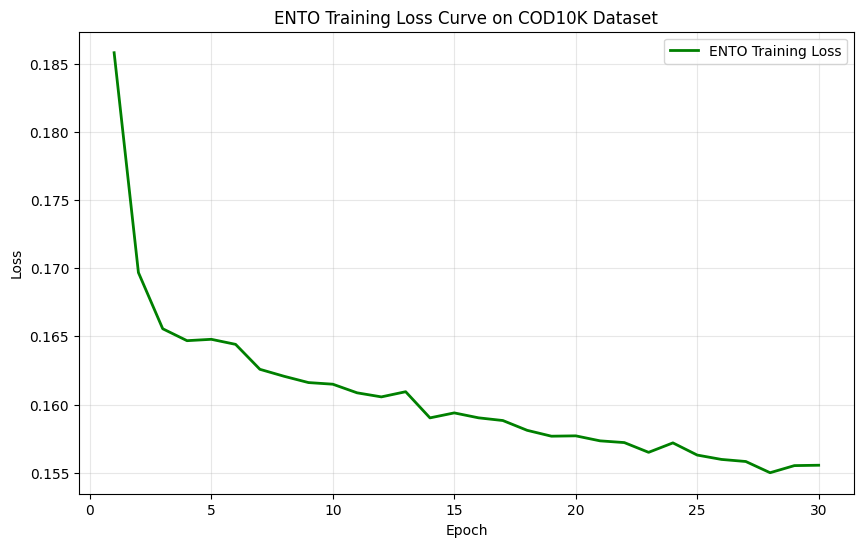

Visualizing ENTO results on test data:


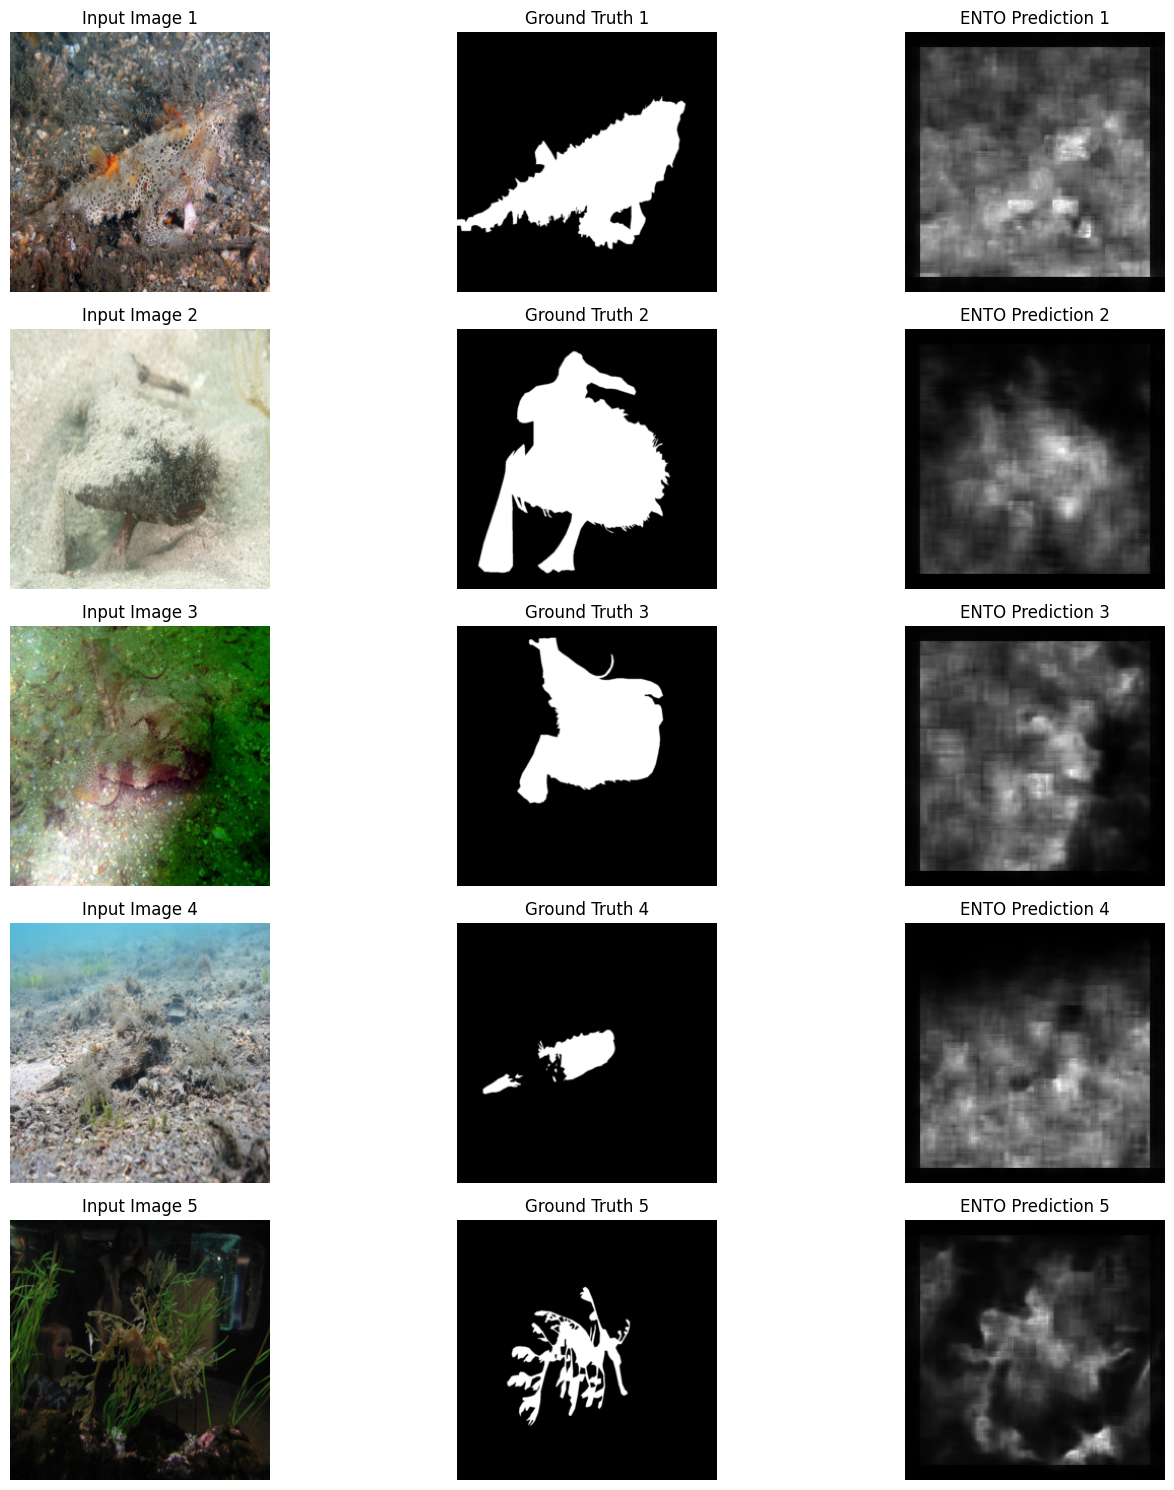


ENTO Model Summary:
Total parameters: 758,145
Trainable parameters: 758,145


In [21]:
# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, 'g-', linewidth=2, label='ENTO Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ENTO Training Loss Curve on COD10K Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualization function
def visualize_ento_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    dataiter = iter(dataloader)
    images, masks = next(dataiter)

    with torch.no_grad():
        outputs = model(images.to(device))

    plt.figure(figsize=(15, 3 * num_samples))
    for i in range(num_samples):
        # Input image
        plt.subplot(num_samples, 3, 3*i + 1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.title(f"Input Image {i+1}")
        plt.axis('off')

        # Ground truth
        plt.subplot(num_samples, 3, 3*i + 2)
        gt = masks[i].squeeze().cpu().numpy()
        plt.imshow(gt, cmap='gray')
        plt.title(f"Ground Truth {i+1}")
        plt.axis('off')

        # ENTO prediction
        plt.subplot(num_samples, 3, 3*i + 3)
        pred = outputs[i].squeeze().cpu().numpy()
        plt.imshow(pred, cmap='gray')
        plt.title(f"ENTO Prediction {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model
print("Visualizing ENTO results on test data:")
visualize_ento_predictions(model_ento, test_loader, device, num_samples=5)

# Print model summary
total_params = sum(p.numel() for p in model_ento.parameters())
trainable_params = sum(p.numel() for p in model_ento.parameters() if p.requires_grad)
print(f"\nENTO Model Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
